In [1]:
import GEOparse
import pandas as pd
import numpy as np

gse = GEOparse.get_GEO(geo='GSE11223', destdir="./data/geo_cache")

platform_id = gse.metadata['platform_id'][0]
print(f"Platform ID: {platform_id}")

expr_matrix = gse.pivot_samples('VALUE')
expr_matrix_t = expr_matrix.T
expr_df = pd.DataFrame(expr_matrix_t)
gene_symbols = gse.gpls[next(iter(gse.gpls))].table.set_index('ID').GENE_SYMBOL.dropna()
expr_df = pd.concat([expr_df.transpose(), gene_symbols], axis=1, join='inner').set_index('GENE_SYMBOL').transpose()

expr_df.head()

09-Dec-2023 14:00:02 DEBUG utils - Directory ./data/geo_cache already exists. Skipping.
09-Dec-2023 14:00:02 INFO GEOparse - File already exist: using local version.
09-Dec-2023 14:00:02 INFO GEOparse - Parsing ./data/geo_cache/GSE11223_family.soft.gz: 
09-Dec-2023 14:00:02 DEBUG GEOparse - DATABASE: GeoMiame
09-Dec-2023 14:00:02 DEBUG GEOparse - SERIES: GSE11223
09-Dec-2023 14:00:02 DEBUG GEOparse - PLATFORM: GPL1708
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282855
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282856
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282857
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282858
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282859
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282860
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282861
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282862
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282863
09-Dec-2023 14:00:04 DEBUG GEOparse - SAMPLE: GSM282864
09-Dec-2023 14:00:

Platform ID: GPL1708


GENE_SYMBOL,L3MBTL2,APBA2,MAP3K6,ZNF121,RET,MBD2,CMYA5,CCDC67,FAM73B,TMPRSS2,...,BCKDHB,LCE1F,IL1R1,FLJ20323,EMR1,LOC285749,TNFRSF11B,ANXA2P3,ZIC4,TRIM73
GSM282855,0.038661,-0.13288,-0.042229,-0.21233,NaN,0.15138,NaN,0.79340,-0.067277,1.2731,...,0.31019,0.012690,0.087714,-0.11073,-0.087213,0.10406,-0.43621,0.084885,0.146660,-0.371230
GSM282856,-0.108870,-0.10885,0.042197,-0.23983,-0.11532,0.21129,-0.032859,0.47827,0.036340,1.3350,...,0.31477,0.040888,0.035081,-0.11563,-0.069767,0.10573,-0.38750,0.049830,0.063171,0.091402
GSM282857,-0.044310,-0.13558,0.017986,-0.33934,-0.44221,0.19592,-0.275420,0.14896,-0.054240,1.2206,...,0.35083,0.004195,0.053716,-0.21735,-0.074031,0.12149,-0.53987,-0.220800,0.134950,-0.076405
GSM282858,-0.033416,-0.11883,0.063459,-0.31396,-0.24953,0.21552,0.059959,0.23747,-0.024092,1.1252,...,0.28370,-0.000777,0.074099,-0.14827,-0.103450,0.19855,-0.55846,-0.327790,0.078462,0.376460
GSM282859,-0.043601,-0.16435,0.072020,-0.43590,-0.44009,0.23526,-0.341260,-0.17687,-0.055102,1.1526,...,0.31776,0.012371,0.108000,-0.10784,-0.091149,0.12446,-0.54040,-0.056164,0.051566,0.164400


In [2]:
y_inflammation = pd.Series(['Inflamed' in  l for l in gse.phenotype_data.source_name_ch1], index=gse.phenotype_data.index)
y_uc = pd.Series(['UC' in l for l in gse.phenotype_data.source_name_ch1], index=gse.phenotype_data.index)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

X = expr_df.dropna(axis=1) 
y = y_inflammation.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.8780487804878049
AUC: 0.8695054945054945


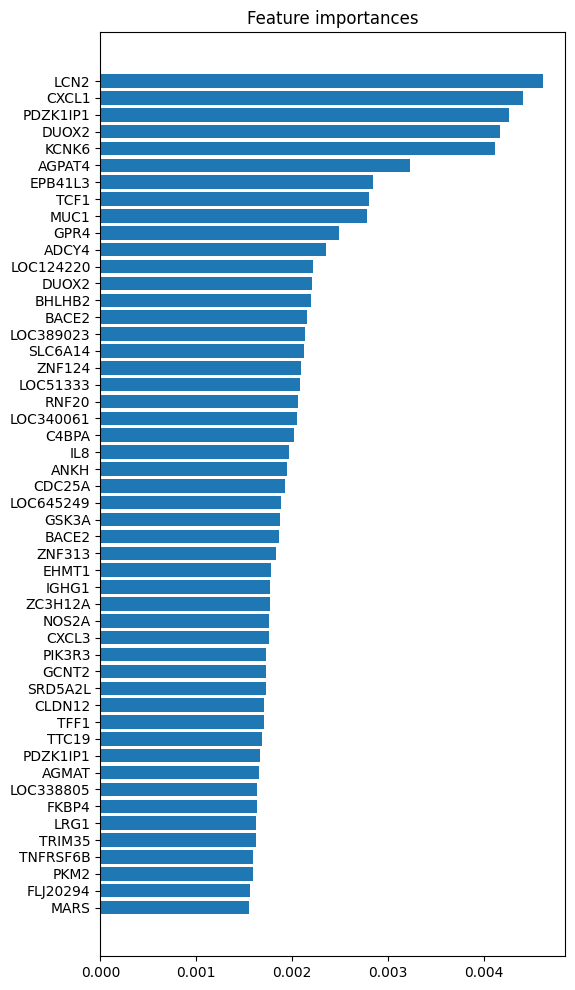

In [4]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:50]

plt.figure(figsize=(6, 12))
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), X.columns[indices])
# sort the y axis labels so they are in descending order of feature importance
plt.gca().invert_yaxis()
plt.show()
